In [29]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = sns.load_dataset('flights')

### 1. Train/ Test Split

In [3]:
train = df.iloc[:120] # copy prevents warning
test = df.iloc[120:]

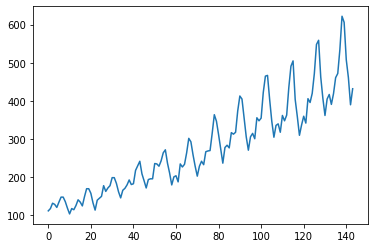

In [4]:
df['passengers'].plot()

### 2. Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
X = train.index.astype(int).values / 1000_000_000_000
X = X.reshape(-1, 1)
X.shape

(120, 1)

In [13]:
y = train['passengers']
y

0      112
1      118
2      132
3      129
4      121
      ... 
115    505
116    404
117    359
118    310
119    337
Name: passengers, Length: 120, dtype: int64

In [8]:
m = LinearRegression()
m.fit(X, y)
m.score(X, y)  # R^2 (1.0-good, 0.0-bad)

0.8355617995786744

In [9]:
Xtest = test.index.astype(int).values / 1000_000_000_000
Xtest = Xtest.reshape(-1, 1)
ytest = test['passengers']

In [10]:
ypred = m.predict(Xtest)
ytrpred = m.predict(X)

### 3. Other Naive Models

In [11]:
# 3a) predict the mean
mean = y.mean()
ymean = [mean] * 24
mean

245.90833333333333

In [19]:
# 3b) predict the last value seen
last = list(y)[-1]
ylast = [last] * 24
last

337

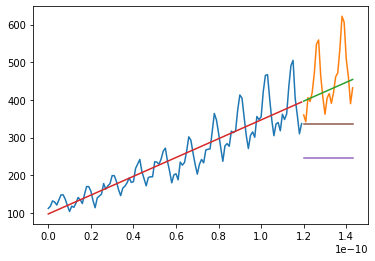

In [20]:
plt.plot(X, y)
plt.plot(Xtest, ytest)
plt.plot(Xtest, ypred)
plt.plot(X, ytrpred)

plt.plot(Xtest, ymean)   # baseline model: mean
plt.plot(Xtest, ylast)

### 4. Calculate the MSE

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
mean_squared_error(ytest, ypred)

5593.208874769767

In [24]:
mean_squared_error(y, ytrpred)

1469.8938776901948

### 5. Decomposition
  1. Decompose the time series
  2. Train a model on the decomposed data
  3. Create a prediction from the model
  4. Recompose the predictions

In [25]:
train['diff'] = train['passengers'].diff()  # differential
train['pct'] = train['passengers'].pct_change() 

/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# every month, the passenger number grows by:
mean = train['diff'].mean()
ypred_meandiff = [mean] * 24

In [34]:
mean = train['pct'].mean() + 1
ypred_meanpct = [mean] * 24
ypred_meanpct

[1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263,
 1.0149118154591263]

#### Reconstruct:

In [35]:
# reconstruct to the original scale
# opposite of diff: cumulative sum
ypred_md = np.cumsum(ypred_meandiff) + last
ypred_md

array([338.8907563 , 340.78151261, 342.67226891, 344.56302521,
       346.45378151, 348.34453782, 350.23529412, 352.12605042,
       354.01680672, 355.90756303, 357.79831933, 359.68907563,
       361.57983193, 363.47058824, 365.36134454, 367.25210084,
       369.14285714, 371.03361345, 372.92436975, 374.81512605,
       376.70588235, 378.59663866, 380.48739496, 382.37815126])

In [33]:
# opposite of pct_change: cumulative product
ypred_mp = np.cumprod(ypred_meanpct) * last
ypred_mp

array([342.02528181, 347.12549969, 352.30177109, 357.55523008,
       362.88702769, 368.29833208, 373.79032884, 379.36422125,
       385.02123051, 390.76259604, 396.58957576, 402.50344633,
       408.50550344, 414.59706212, 420.779457  , 427.05404262,
       433.42219369, 439.88530546, 446.44479396, 453.10209634,
       459.85867118, 466.71599882, 473.67558167, 480.73894453])

#### Seasonality

In [36]:
def decompose(train):
    # take out trend + variance change
    train['pct'] = train['passengers'].pct_change()
    mm = train.groupby('month')['pct'].mean()
    noise = train['pct'] - list(mm) * 10 # 10y training data
    return noise, mm

In [37]:
noise, mm = decompose(train)

/Users/lara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# 1. use the monthly mean percentual growth rates
# 2. calculate the cumulative product
def recompose(mm):
    two_years = np.array(list(mm) * 2) + 1 # create a list of 24 
    result = np.cumprod(two_years) * last
    return result
# we have 12 parameters (in mm)

In [39]:
ypred_seasperc = recompose(mm)

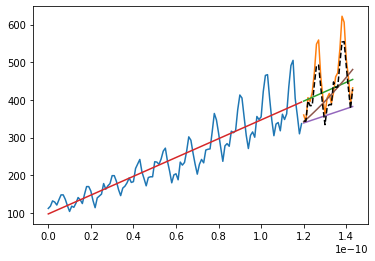

In [40]:
plt.plot(X, y)
plt.plot(Xtest, ytest)
plt.plot(Xtest, ypred)
plt.plot(X, ytrpred)

plt.plot(Xtest, ypred_md)   # mean diff
plt.plot(Xtest, ypred_mp)   # mean 
plt.plot(Xtest, ypred_seasperc, 'k--')  # mean seasonal percentage

In [41]:
mean_squared_error(ytest, ypred_seasperc)

1135.4092228180252

### Other models that use ML
* Linear Regression with Autoregression
* Random Forest Regressor
* Exponentional Smoothing
* ARIMA
* LSTMs (neural network)